In [1]:
from analysis import *

In [2]:
configs = ['calog', 'lem', 'terz', 'con', 'calog2', 'wink', 'power', 'lem2_correct', 'teles', 'pst', 'nothing']
sine_sweeps = ['minus6', 'minus3', '0']
file_start = 'sine_sweep'

In [3]:
# Specify the directory path
directory = 'SDI'

# Get a list of all CSV files in the directory
csv_files = [directory + '/' + file for file in os.listdir(directory) if file.endswith('.csv')]

csv_files.sort()

In [ ]:
sine_data_files = {}

for file in csv_files:
    if "sine_sweep" in file:
        print(file)
        for axis in ['X', 'Y','Z']:
            data = read_sdi_data(file, axis=axis)
            pulse = createPulseDF(data)
            try:
                starts, ends = findPulses(pulse, threshold=0.1)
                amplitudes = findAmplitudes(starts, ends, data)
            except:
                starts, ends = findPulses(pulse, threshold=1)
                amplitudes = findAmplitudes(starts, ends, data)

            sine_data_files.update({file + ' ' + axis: amplitudes})

sine_data_files

<Figure size 640x480 with 0 Axes>

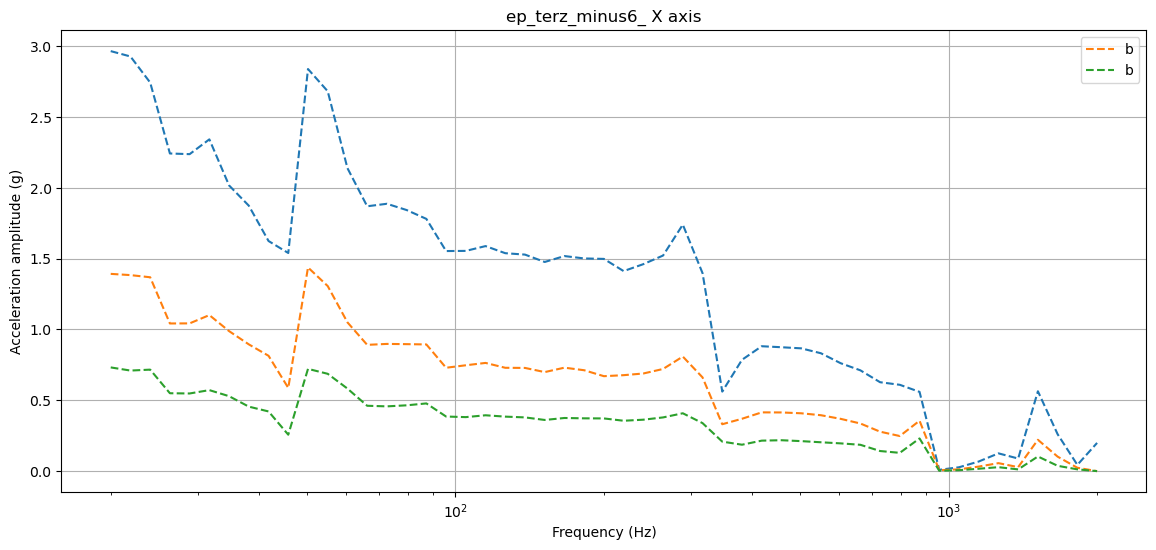

In [5]:
frequencies = giveLogSpaceFarray(20,2000,50)

cutTheStringOff = len('Leandro/SDI/sine_sweep_terz_')
secondCutOff = len('Leandro/SDI/')
thirdCutOff = len('sien_sweep_terz')

plt.clf()
plt.figure(figsize=(14, 6))

for file in csv_files:
        if 'sine_sweep' not in file: continue
        if 'terz' not in file: continue
        if 'post' in file: continue

        for axis in ['X']:
            keyname = file + ' ' + axis
            amplitudes = sine_data_files[keyname]
            cut = min(len(amplitudes), len(frequencies))
            plt.plot(frequencies[:cut], amplitudes[:cut], '--', label = file[cutTheStringOff:-4])
        title = file

plt.grid()
plt.ylabel('Acceleration amplitude (g)')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.title(f'{title[secondCutOff:secondCutOff+thirdCutOff]} X axis')
plt.legend()
plt.show()

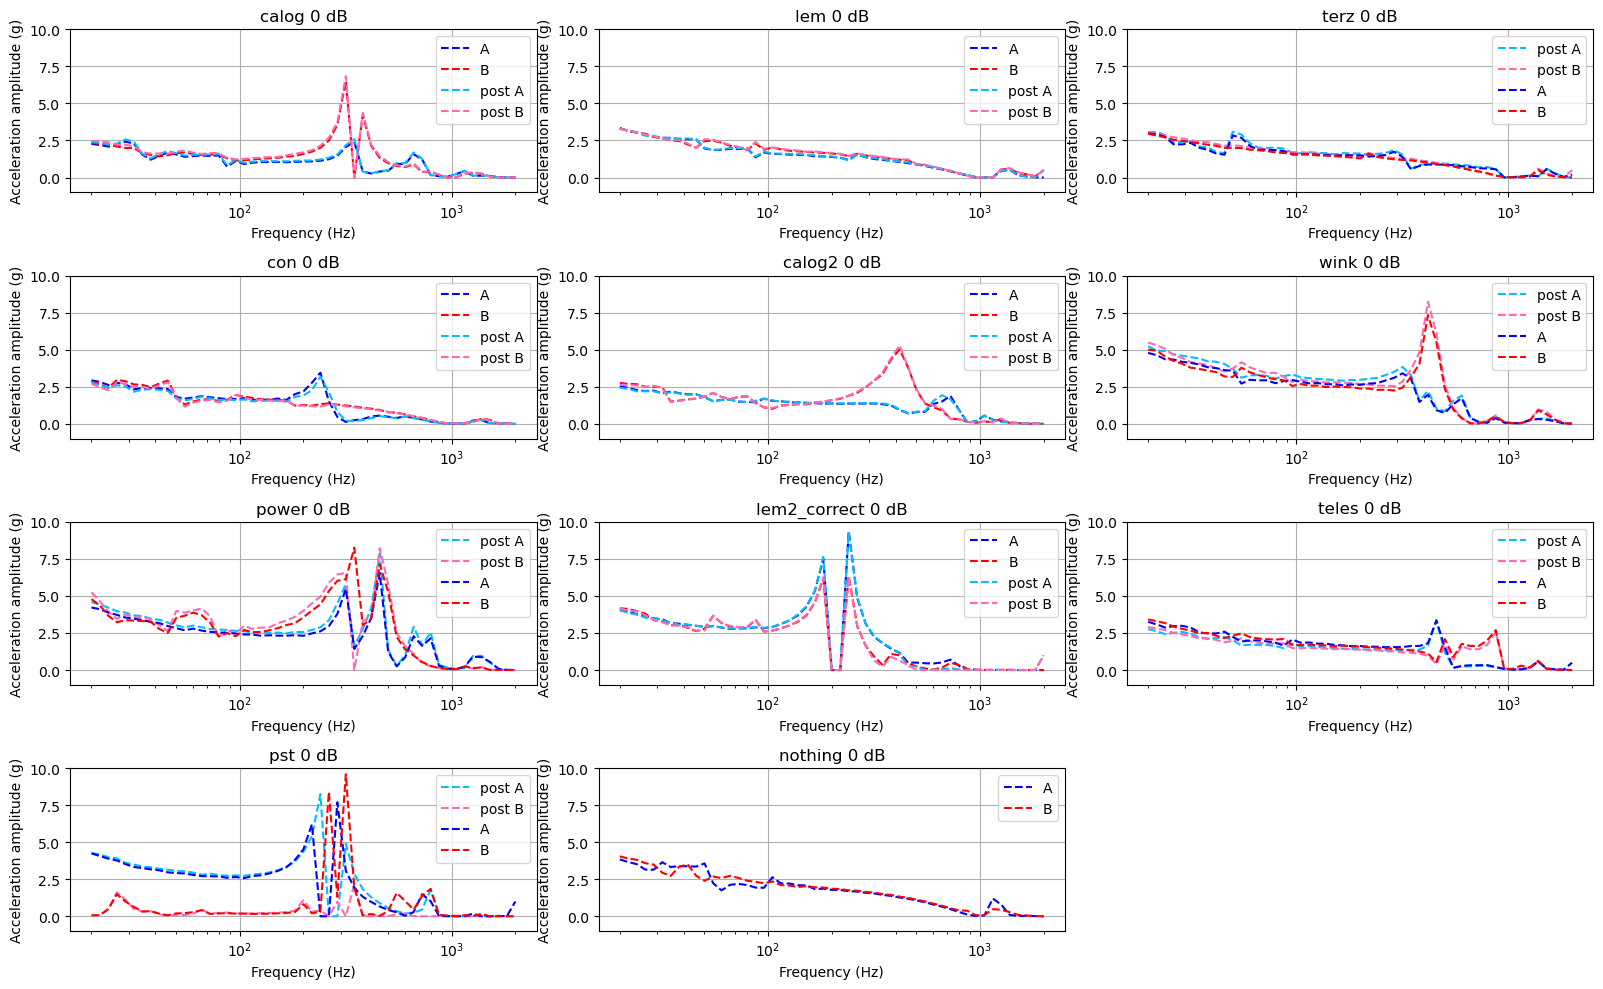

In [6]:
import matplotlib.pyplot as plt

frequencies = giveLogSpaceFarray(20, 2000, 50)

axis_map = {'X' : 'A', 'Z' : 'B'}
color_map = {'X': 'blue', 'Z' : 'red'}
post_color_map = {'X' : 'deepskyblue', 'Z' : 'hotpink'}

# Determine the layout of subplots (e.g., 2 rows, 3 columns)
num_configs = len(configs)
rows = int(num_configs ** 0.5) + 1
cols = (num_configs // rows) + (num_configs % rows > 0)

# Create a figure with subplots
fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
axs = axs.flatten()  # Flatten in case we have a 2D array of axes

# Loop through configurations and corresponding axes
for i, config in enumerate(configs):
    ax = axs[i]  # Get the current axis
    
    for file in csv_files:
        if 'sine_sweep' not in file: continue
        if config + '_0' not in file: continue
        colors = color_map
        name = ''
        if 'post' in file: 
            colors = post_color_map
            name = 'post '

        for axis in ['X', 'Z']:
            keyname = file + ' ' + axis
            amplitudes = sine_data_files[keyname]
            cut = min(len(amplitudes), len(frequencies))
            ax.plot(frequencies[:cut], amplitudes[:cut], '--', label= name + axis_map[axis], color = colors[axis])

    ax.grid()
    ax.set_ylabel('Acceleration amplitude (g)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_xscale('log')
    ax.set_title(f'{config} 0 dB')
    ax.set_ylim(-1,10)
    ax.legend()

# Hide any unused subplots
for j in range(len(configs), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout for better visualization
fig.tight_layout()
plt.show()


In [7]:
import re

axis_map = {'X' : 'A', 'Y' : 'Plate','Z' : 'B'}

# Function to extract type and db
def extract_info(file_path):
    # Use regex to extract type and db from the file path
    match = re.search(r"(?P<type>sine_sweep).*_(?P<db>-?\w+)db", file_path)
    if match:
        return {
            "type": match.group("type"),
            "dB": match.group("db").replace("_", "")  # Remove any stray underscores
        }
    return None


# Prepare the data structure to store all configurations, files, axes, and their corresponding values
data = []

# Loop through configurations
for config in configs:
    for file in csv_files:
        if 'sine_sweep' not in file:
            continue
        if config + '_' not in file:
            continue
        name = 'before'
        if 'post' in file:
            name = 'after'

        # print(extract_info(file))        
        for axis in ['X', 'Y', 'Z']:
            keyname = file + ' ' + axis
            amplitudes = sine_data_files[keyname]
            cut = min(len(amplitudes), len(frequencies))
            
            # Collect data
            for freq, amp in zip(frequencies[:cut], amplitudes[:cut]):
                data.append({
                    "Configuration": config,
                    # "Type" : extract_info(file)['type'],
                    "dB" : extract_info(file)['dB'],
                    "Axis": axis_map[axis] + ' ' + name,
                    "Frequency (Hz)": round(freq,3),
                    "Amplitude (g)": round(amp,3)
                })

# Convert the data into a Pandas DataFrame
df = pd.DataFrame(data)

In [8]:
"""
This is to save 0db files separately because they have before and after shakes (except for 'nothing')

"""

data = df
# Filter and drop duplicates
new_data = data.iloc[:, [0, 1, 3]]
new_data = new_data.drop_duplicates()

# Filter for rows where dB == '0'
new_data_zero_db = new_data[(new_data['dB'] == '0') & (new_data['Configuration'] != 'nothing')].copy()  # Use .copy() to create a new DataFrame

# Add new columns with None values
new_data_zero_db['A before'] = None
new_data_zero_db['A after'] = None
new_data_zero_db['B before'] = None
new_data_zero_db['B after'] = None
new_data_zero_db['Plate before'] = None
new_data_zero_db['Plate after'] = None

axes = ['A before', 'A after', 'B before', 'B after', 'Plate before', 'Plate after']

for index, row in new_data_zero_db.iterrows():
    for axis in axes:
        amp = data[
            (data.Configuration == row.Configuration) & 
            (data.dB == row.dB) & 
            (data['Frequency (Hz)'] == row['Frequency (Hz)']) & 
            (data.Axis == axis)
        ]['Amplitude (g)']
        
        if not amp.empty:
            # Use .loc to update the original DataFrame
            new_data_zero_db.loc[index, axis] = float(amp.iloc[0])

folder_name = 'sine_sweep_results'
checkFolder(folder_name)

for config in configs:
    sub_data = new_data_zero_db[new_data_zero_db['Configuration'] == config]
    sub_data.to_csv(f"./{folder_name}/{config}_0_db.csv", index=False)

Folder 'sine_sweep_results' already exists.


In [9]:
"""
This is to save the rest of the files separately because they don't have before and after shakes)

"""


# Filter and drop duplicates
new_data = data.iloc[:, [0, 1, 3]]
new_data = new_data.drop_duplicates()

# Filter for rows where dB == '0'
new_data_zero_db = new_data[(new_data['dB'] != '0') | (new_data['Configuration'] == 'nothing')].copy()  # Use .copy() to create a new DataFrame

# Add new columns with None values
new_data_zero_db['A'] = None
new_data_zero_db['B'] = None
new_data_zero_db['Plate'] = None

axes = ['A', 'B', 'Plate']

for index, row in new_data_zero_db.iterrows():
    for axis in axes:
        amp = data[
            (data.Configuration == row.Configuration) & 
            (data.dB == row.dB) & 
            (data['Frequency (Hz)'] == row['Frequency (Hz)']) & 
            (data.Axis == axis + ' before')
        ]['Amplitude (g)']
        
        if not amp.empty:
            # Use .loc to update the original DataFrame
            new_data_zero_db.loc[index, axis] = float(amp.iloc[0])

for config in configs:
    if config == 'nothing': continue
    for db in ['minus3', 'minus6']:
        sub_data = new_data_zero_db[(new_data_zero_db['Configuration'] == config) & (new_data_zero_db['dB'] == db)]
        sub_data.to_csv(f"./sine_sweep_results/{config}_{db}_db.csv", index=False)


sub_data = new_data_zero_db[(new_data_zero_db['Configuration'] == 'nothing')]
sub_data.to_csv(f"./{folder_name}/nothing_0_db.csv", index=False)
